Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None


Exception ignored in: <function Viewer.__del__ at 0x0000021E419343A0>
Traceback (most recent call last):
  File "C:\Users\Yang Yue\.conda\envs\stat_430_tensorflow\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\Yang Yue\.conda\envs\stat_430_tensorflow\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\Yang Yue\.conda\envs\stat_430_tensorflow\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "C:\Users\Yang Yue\.conda\envs\stat_430_tensorflow\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "C:\Users\Yang Yue\.conda\envs\stat_430_tensorflow\lib\_weakrefset.py", line 110, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x0000021E3BC66EA0; to 'Win32Window' at 0x0000021E35762490>
Exception ignored in: <function Viewer.__del__ at 0

0 	: Episode || Rewards:  -151.2014489455825 	 || Average Rerward:  -151.2014489455825 	 epsilon:  0.995
1 	: Episode || Rewards:  -155.82820666552809 	 || Average Rerward:  -153.51482780555529 	 epsilon:  0.990025
2 	: Episode || Rewards:  -129.49165655108757 	 || Average Rerward:  -145.50710405406605 	 epsilon:  0.985074875
3 	: Episode || Rewards:  -245.75893415708416 	 || Average Rerward:  -170.57006157982056 	 epsilon:  0.9801495006250001
4 	: Episode || Rewards:  -68.55435776485558 	 || Average Rerward:  -150.16692081682757 	 epsilon:  0.9752487531218751
5 	: Episode || Rewards:  -112.99945937697957 	 || Average Rerward:  -143.97234391018623 	 epsilon:  0.9703725093562657
6 	: Episode || Rewards:  -148.34012834317673 	 || Average Rerward:  -144.59631311489915 	 epsilon:  0.9655206468094844
7 	: Episode || Rewards:  -84.62958264253848 	 || Average Rerward:  -137.10047180585408 	 epsilon:  0.960693043575437
8 	: Episode || Rewards:  -274.34316545288885 	 || Average Rerward:  -152.3

<Figure size 432x288 with 0 Axes>

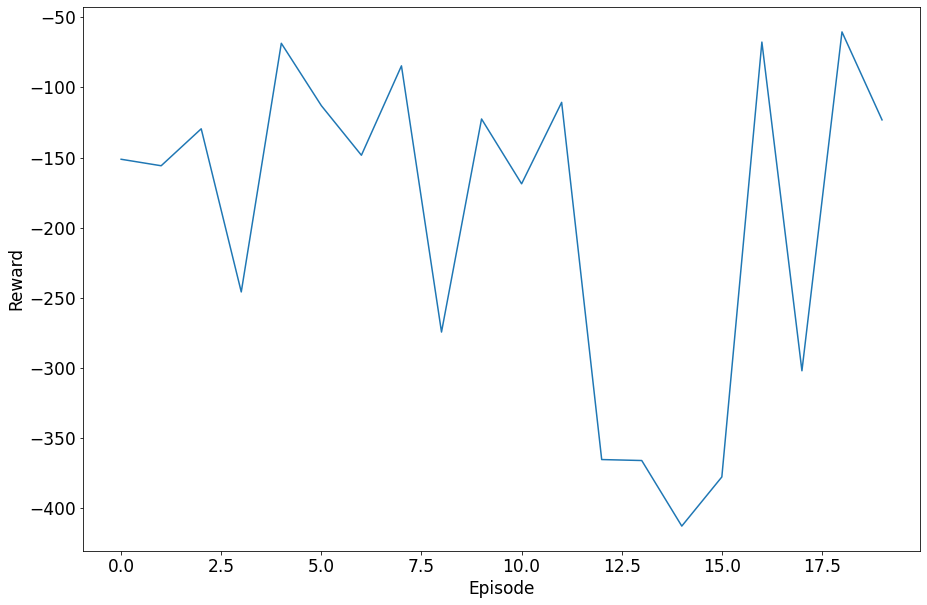

<Figure size 432x288 with 0 Axes>

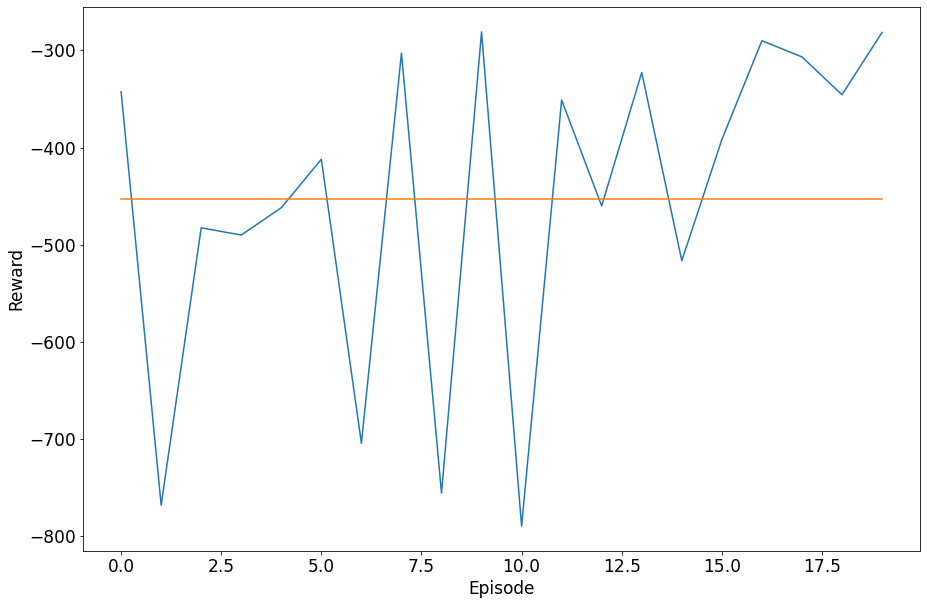

In [4]:
import gym
import random
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

warnings.filterwarnings('ignore')

class DQN:
    def __init__(self,env,learning_rate,discount,epsilon,epsilon_decay):
        
        self.env = env
        self.state_space = env.observation_space
        self.action_space = env.action_space
        self.counter = 0
        
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        
        self.rewards_list = []
        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.num_action_space = env.action_space.n
        self.num_state_space = env.observation_space.shape[0]
        self.model = self.initialize_model()
        
    def initialize_model(self):
        # Not sure about last activation
        model = Sequential()
        model.add(Dense(512,input_dim=self.num_state_space,activation=relu))
        model.add(Dense(256,activation=relu))
        model.add(Dense(self.num_action_space,activation=linear))
        
        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(learning_rate=self.learning_rate))
        print(model.summary())
        return model
    
    def get_action(self,state):
        # Return a number within the range
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)
        
        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])
    
    def add_to_memory(self,state,action,reward,next_state,done):
        self.replay_memory_buffer.append((state,action,reward,next_state,done))
        
    def learn_and_update_weights(self):
        # Check replay_memory_buffer size
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return
        
        # Early stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return
        
        random_sample = self.get_random_sample_from_mem()
        states,actions,rewards,next_states,done_list = self.get_attributes_from_sample(random_sample)
        targets = rewards+self.discount*(np.amax(self.model.predict_on_batch(next_states),axis=1))*(1-done_list)
        target_vec = self.model.predict_on_batch(states)
        indices = np.array([i for i in range(self.batch_size)])
        target_vec[[indices],[actions]] = targets
        
        self.model.fit(states,target_vec,epochs=1,verbose=0)
        
    def get_attributes_from_sample(self,random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return states,actions,rewards,next_states,done_list
    
    def get_random_sample_from_mem(self):
        random_sample = random.sample(self.replay_memory_buffer,self.batch_size)
        return random_sample
    
    def train(self,episodes,can_stop=True):
        for episode in range(episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state,[1,self.num_state_space])
            for step in range(num_steps):
                env.render()
                received_action = self.get_action(state)
                next_state,reward,done,info = env.step(received_action)
                next_state = np.reshape(next_state,[1,self.num_state_space])
                # Store in replay memory
                self.add_to_memory(state,received_action,reward,next_state,done)
                # Add up rewards
                reward_for_episode += reward
                state = next_state
                self.update_counter()
                self.learn_and_update_weights()
                
                if done:
                    break
            self.rewards_list.append(reward_for_episode)
                
            # Decay the epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                    
            # Check for breaking condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 200 and can_stop:
                print("DQN training complete...")
                break
            print(episode,"\t: Episode || Rewards: ",reward_for_episode,"\t || Average Rerward: ",last_rewards_mean,"\t epsilon: ",self.epsilon)
                
    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter%step_size
        
    def save(self,name):
        self.model.save(name)
        
def test_trained_model(trained_model):
    rewards_list = []
    num_test_episode = 20
    env = gym.make("LunarLander-v2")
    print("Start testing of the trained model...")
        
    step_count = 1000
        
    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_state_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state,[1,num_state_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state,reward,done,info = env.step(selected_action)
            new_state = np.reshape(new_state,[1,num_state_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        print(test_episode,"\t: Episode || Reward: ",reward_for_episode)
            
    return rewards_list
    
def plot_df(df,chart_name,title,xlabel,ylabel):
    plt.rcParams.update({"font.size":17})
    df['rolling_mean'] = df[df.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15,10))
    plt.close()
    plt.figure()
        
    plot = df.plot(linewidth=1.5,figsize=(15,10))
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    fig = plot.get_figure()
    plt.legend().set_visible(False)
    fig.savefig(chart_name)
        
def plot_df2(df,chart_name,title,xlabel,ylabel):
    df['mean'] = df[df.columns[0]].mean()
    plt.rcParams.update({"font.size":17})
    plt.figure(figsize=(15,10))
    plt.close()
    plt.figure()
        
    plot = df.plot(linewidth=1.5,figsize=(15,10))
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    #plt.xlim((0,100))
    #plt.ylim((0,300))
    plt.legend().set_visible(False)
    fig = plot.get_figure()
    fig.savefig(chart_name)
        
def plot_experiments(df,chart_name,title,xlabel,ylabel,ylimit):
    plt.rcParams.update({"font.size":17})
    plt.figure(figsize=(15,10))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1,figsize=(15,10),title=title)
    plt.set_xlabel(xlabel)
    plt.set_ylabel(ylabel)
    plt.ylim(ylimit)
    fig = plot.get_figure()
    fig.savefig(chart_name)
        
def run_experiment_for_discount():
    print("Running expriement for discount...")
    env = gym.make("LunarLander-v2")
        
    # Set seed
    env.seed(21)
    np.random.seed(21)
        
    # Parameters
    learning_rate = 0.001
    epsilon = 1.0
    epsilon_decay = 0.995
    discount_list = [0.99,0.9,0.8,0.7]
    episodes = 1000
        
    rewards_list_for_discounts = []
    for discount_value in discount_list:
        model = DQN(env,learning_rate,discount_value,epsilon,epsilon_decay)
        print("Training model for discount: {}".format(discount_value))
        model.train(episodes,False)
        rewards_list_for_discounts.append(model.rewards_list)
            
    pickle.dump(rewards_list_for_discounts,open("rewards_list_for_discounts.p","wb"))
    rewards_list_for_discounts = pickle.load(open("rewards_list_for_discounts.p","rb"))
        
    discount_rewards_pd = pd.DataFrame(index=pd.Series(range(1,episodes+1)))
    for i in range(len(discount_list)):
        col_name = "discount="+str(discount_list[i])
        discount_rewards_pd[col_name] = rewards_list_for_discounts[i]
    plot_experiments(discount_rewards_pd,"GFigure: Rewards per Episode for Different Discount Values",
                     "Figure: Rewards per Episode for Different Discount Values","Episodes","Reward",(-600,300))
        
def run_experiment_for_lr():
    print("Running experiment for learning rate...")
    env = gym.make("LunarLander-v2")
        
    # Set seed
    env.seed(21)
    np.random.seed(21)
        
    # Parameters
    learning_rate_list = [0.0001,0.001,0.01,0.1]
    epsilon = 1.0
    epsilon_decay = 0.995
    discount = 0.99
    episodes = 1000
        
    rewards_list_for_lrs = []
    for lr_value in learning_rate_list:
        model = DQN(env,lr_value,discount,epsilon,epsilon_decay)
        print("Training model for learning rate: {}".format(lr_value))
        model.train(episodes,False)
        rewards_list_for_lrs.append(model.rewards_list)
            
    pickle.dump(rewards_list_for_lrs,open("rewards_list_for_lrs.p","wb"))
    rewards_list_for_lrs = pickle.load(open("rewards_list_for_lrs.p","rb"))
        
    lr_rewards_pd = pd.DataFrame(index=pd.Series(range(1,episodes+1)))
    for i in range(len(learning_rate_list)):
        col_name = "lr="+str(learning_rate_list[i])
        lr_rewards_pd[col_name] = rewards_list_for_lrs[i]
    plot_experiments(lr_rewards_pd,"Figure: Rewards per Episode for Different Learning Rates",
                     "Figure: Rewards per Episode for Different Learning Rates","Episodes","Reward",(-2000,300))
        
def run_experiment_for_decay():
    print("Running experiment for epsilon decay...")
    env = gym.make("LunarLander-v2")
        
    # Set seed
    env.seed(21)
    np.random.seed(21)
        
    # Parameters
    learning_rate = 0.001
    epsilon = 1.0
    epsilon_decay_list = [0.999,0.995,0.990,0.9]
    discount = 0.99
    episodes = 1000
        
    rewards_list_for_decays = []
    for decay_value in epsilon_decay_list:
        model = DQN(env,learning_rate,discount,epsilon,decay_value)
        print("Training model for epsilon decay: {}".format(decay_value))
        model.train(episodes,False)
        rewards_list_for_decays.append(model.rewards_list)
            
    pickle.dump(rewards_list_for_decays,open("rewards_list_for_decays.p","wb"))
    rewards_list_for_decays = pickle.load(open("rewards_list_for_decays.p","rb"))
        
    decay_rewards_pd = pd.DataFrame(index=pd.Series(range(1,episodes+1)))
    for i in range(len(epsilon_decay_list)):
        col_name = "decay="+str(epsilon_decay_list[i])
        decay_rewards_pd[col_name] = rewards_list_for_decays[i]
    plot_experiments(decay_rewards_pd,"Figure: Rewards per Episode for Different Epsilon Decays",
                     "Figure: Rewards per Episode for Different Epsilon Decays","Episodes","Reward",(-600,300))
        
if __name__ == "__main__":
    env = gym.make("LunarLander-v2")
    
    # Set seed
    env.seed(21)
    np.random.seed(21)
    
    # Parameters
    learning_rate = 0.001
    epsilon = 1.0
    epsilon_decay = 0.995
    discount = 0.99
    episodes = 20
    
    model = DQN(env,learning_rate,discount,epsilon,epsilon_decay)
    model.train(episodes,True)
    
    # Save model
    save_dir = "saved_models"
    model.save(save_dir+"trained_model.h5")
    # Save rewards list
    pickle.dump(model.rewards_list,open(save_dir+"train_rewards_list.p","wb"))
    rewards_list = pickle.load(open(save_dir+"train_rewards_list.p","rb"))
    
    # Plot rewards
    reward_df = pd.DataFrame(rewards_list)
    plot_df(reward_df,"Figure: Reward for Each Training Episode","Figure: Reward for Each Training Episode","Episode","Reward")
    
    # Test the model
    trained_model = load_model(save_dir+"trained_model.h5")
    test_rewards = test_trained_model(trained_model)
    pickle.dump(test_rewards,open(save_dir+"test_rewards.p","wb"))
    test_rewards = pickle.load(open(save_dir+"test_rewards.p","rb"))
    
    plot_df2(pd.DataFrame(test_rewards),"Figure: Reward for Each Testing Episode","Figure: Reward for Each Testing Episode","Episode","Reward")
    print("Training and testing completed...")
    
    # Run experiments for hyper-parameter
    # run_experiment_for_discont()
    # run_experiment_for_lr()
    # run_experiment_for_decay()

            

    